In [1]:
# Import packages
%load_ext autoreload
%autoreload 

import numpy as np
import matplotlib.pyplot as plt
import torch
from scipy.optimize import curve_fit
import seaborn as sns
from time import time as tm
from NeuroRNN import RateModel
from NeuroRNN import SpikingModel
from utils import GetBlockErdosRenyi, GetSpikeCounts, PoissonProcess, GetOneAngle, ConvWithExp, ToNP


# Choose a device
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'
print('Device =',device)



Device = mps


In [2]:
### These are all of the parameters that you might want to change.

# Number of neurons in recurrent net
N = 5000

# Number of sims to run in parallel
batch_size = 1

# Duration of simulation in ms
T = 1250
dt = 0.1

# Burn-in period for compring time averages and rates
Tburn = 250

# Number of excitatory, inhibitory, and external neurons
Ne = int(N*.8)
Ni = N-Ne
Nx = int(N*.2)

# Connection weights
jee = 25.0
jei = -150.0
jie = 112.5
jii = -250.0
jex = 180.0
jix = 135.0
Jm = 15*np.array([[jee, jei], [jie, jii]])/np.sqrt(N)
Jxm = 15*np.array([[jex], [jix]])/np.sqrt(N)

# Connection probabilities
p=0.1
P = np.array([[p, p], [p, p]])
Px = np.array([[p], [p]])

# Synaptic timescales
taue = 8.0
taui = 4.0
taux = 10.0

# Rate of external population
rx=10/1000

# EIF Neuron Parameters
NeuronParams = {}
NeuronParams['taum'] = 15.0
NeuronParams['EL'] = -72.0
NeuronParams['Vth'] = 0.0
NeuronParams['Vre'] = -75.0
NeuronParams['VT'] = -55.0
NeuronParams['DT'] = 1.0

# Time resolution for recording
dtRecord=1

# Indices of neurons from which to record membrane potential (V)
VIRecord=[0,1,2]

In [3]:
### Set all of the parameters, and build model.

with torch.no_grad():
    
    # Disctretized time
    time = np.arange(0,T,dt)
    Nt = len(time)
    Nburn = int(Tburn/dt)

    # Get connectivity matrix
    t0=tm()
    J = GetBlockErdosRenyi((Ne,Ni),Jm,P).to(device)
    Jx = GetBlockErdosRenyi((Nx,),Jxm,Px,(Ne,Ni)).to(device)
    tJ = tm()-t0
    print('Time to generate connectivity:',tJ,'s')

    # Array of synaptic timescales
    tausyn = torch.zeros(N).to(device)
    tausyn[:Ne] = taue
    tausyn[Ne:] = taui

    # Baseline input
    x0 = torch.zeros(batch_size,N).to(device)

    # Generate Poisson process external spike trains
    # and convolve them with an exponential kernel to 
    # get synaptic output of external pop
    t0=tm()
    Sx = PoissonProcess(rx,dt,batch_size,Nx,T,'dense').to(device)
    Yx = ConvWithExp(Sx,taux,dt)
    tSx=tm()-t0
    print('Time to generate external spike trains and currents:',tSx)

    # Build model
    model = SpikingModel(J,tausyn,Jx,'EIF',NeuronParams).to(device)
    



Time to generate connectivity: 0.3281590938568115 s
Time to generate external spike trains and currents: 0.11247086524963379


In [4]:
### Run simulation, store some results

with torch.no_grad():
    
    t0=tm()
    SimResults = model(x0,dt,Yx,T,Tburn=Tburn,dtRecord=dtRecord,VIRecord=VIRecord)
    tSpikingSim = tm()-t0
    print('Time for spiking sim =',tSpikingSim,'s')
    
    r = ToNP(SimResults['r'].squeeze())
    re = r[:Ne]
    ri = r[Ne:]
    
    print('Mean E and I rates:',1000*re.mean(),1000*ri.mean(),'Hz')

    R=ToNP(model.recurrent_layer(SimResults['r']).squeeze())
    X=ToNP(model.input_layer(Yx.mean(axis=1)).squeeze())
    Z=R+X



Time for spiking sim = 26.71225118637085 s
Mean E and I rates: 5.405249539762735 13.937999494373798 Hz


Text(0, 0.5, 'V (mV)')

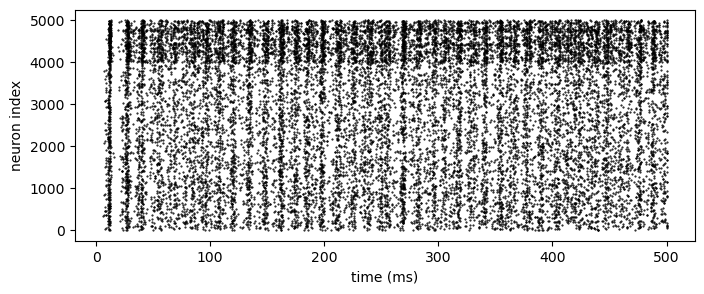

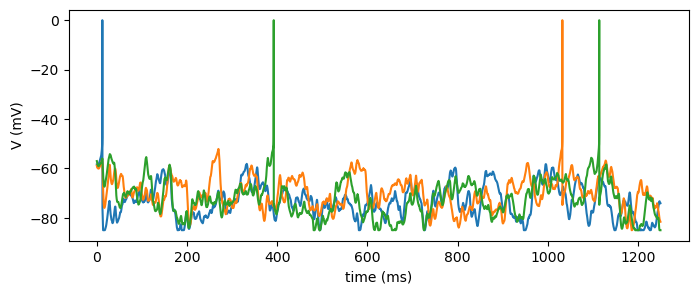

In [5]:
# Get spike times and neuron indices for raster plot
SpikeTimes,NeuronInds=np.nonzero(ToNP(SimResults['S'].squeeze()))
SpikeTimes*=dtRecord

# Make a raster plot of a subset of neurons for a subset of time
plt.figure(figsize=(8,3))
MaxPlotTime=500
MaxNeuronInd=np.inf
PlotInds=np.logical_and(SpikeTimes<=MaxPlotTime, NeuronInds<=MaxNeuronInd)
plt.plot(SpikeTimes[PlotInds],NeuronInds[PlotInds],'k.',markersize=1)
plt.xlabel('time (ms)')
plt.ylabel('neuron index')

# Plot membrane potential traces
plt.figure(figsize=(8,3))
plt.plot(time,ToNP(SimResults['V'].squeeze()))
plt.xlabel('time (ms)')
plt.ylabel('V (mV)')


RELU best fit g = 0.0012756856609671408
For a rate model with f(z)=z*(z>0), use: 
sqrt(N)*Jm=
 [[ 0.47838212 -2.87029274]
 [ 2.15271955 -4.78382123]] 
sqrt(N)*Jxm=
 [[3.44435128]
 [2.58326346]]
Recitifed affine best fit g = 0.0019911432592302812 theta = 4.6712526351589245
For a rate model with f(z)=(z-theta)*(z>theta), use:
 theta= 0.00930113319665838 
sqrt(N)*Jm=
 [[ 0.74667872 -4.48007233]
 [ 3.36005425 -7.46678722]] 
sqrt(N)*Jxm=
 [[5.3760868]
 [4.0320651]]

Affine best fit g = 0.0009812868582336392 theta = -2.2590409594352865
For a rate model with f(z)=(z-theta), use:
 theta= -0.0022167672057053583 
sqrt(N)*Jm=
 [[ 0.36798257 -2.20789543]
 [ 1.65592157 -3.67982572]] 
sqrt(N)*Jxm=
 [[2.64947452]
 [1.98710589]]

Linear best fit g = 0.001106386269269977
For a rate model with f(z)=z, use: 
sqrt(N)*Jm=
 [[ 0.41489485 -2.48936911]
 [ 1.86702683 -4.14894851]] 
sqrt(N)*Jxm=
 [[2.98724293]
 [2.2404322 ]]


[]

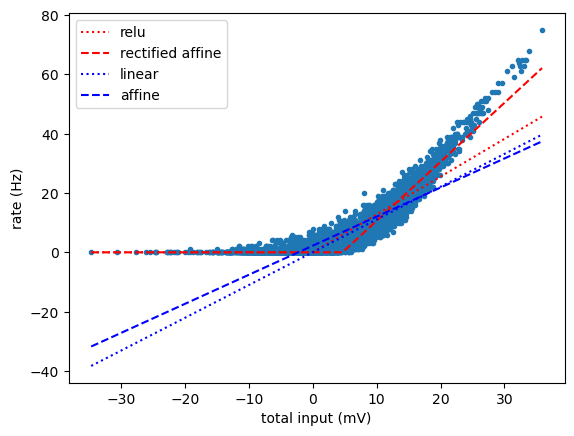

In [6]:
### This code cell fits f-I curves to the results of the simulation.
### These f-I curves can be used for rate model approximations.

# Fit an f-I curve to the data from simulation
def fReLU(z, g):
    return g*(z)*(z>0)
params,_=curve_fit(fReLU, Z, r)
gfitReLU=params[0]
print('\nRELU best fit g =',gfitReLU)
print('For a rate model with f(z)=z*(z>0), use: \nsqrt(N)*Jm=\n',Jm*gfitReLU*np.sqrt(N),'\nsqrt(N)*Jxm=\n',Jxm*gfitReLU*np.sqrt(N))


# Fit an f-I curve to the data from simulation
def fAffineReLU(z, g, theta):
    return g*(z-theta)*(z>theta)
params,_=curve_fit(fAffineReLU, Z, r)
gAffineReLU=params[0]
thetaAffineReLU=params[1]
print('Recitifed affine best fit g =',gAffineReLU,'theta =',thetaAffineReLU)
print('For a rate model with f(z)=(z-theta)*(z>theta), use:\n theta=',gAffineReLU*thetaAffineReLU,'\nsqrt(N)*Jm=\n',Jm*gAffineReLU*np.sqrt(N),'\nsqrt(N)*Jxm=\n',Jxm*gAffineReLU*np.sqrt(N))



# Fit an f-I curve to the data from simulation
def fAffine(z, g, theta):
    return g*(z-theta)
params,_=curve_fit(fAffine, Z, r)
gfitAffine=params[0]
thetafitAffine=params[1]
print('\nAffine best fit g =',gfitAffine,'theta =',thetafitAffine)
print('For a rate model with f(z)=(z-theta), use:\n theta=',gfitAffine*thetafitAffine,'\nsqrt(N)*Jm=\n',Jm*gfitAffine*np.sqrt(N),'\nsqrt(N)*Jxm=\n',Jxm*gfitAffine*np.sqrt(N))


# Fit an f-I curve to the data from simulation
def fLin(z, g):
    return g*(z)
params,_=curve_fit(fLin, Z, r)
gfitLin=params[0]
print('\nLinear best fit g =',gfitLin)
print('For a rate model with f(z)=z, use: \nsqrt(N)*Jm=\n',Jm*gfitLin*np.sqrt(N),'\nsqrt(N)*Jxm=\n',Jxm*gfitLin*np.sqrt(N))


zplot=np.arange(Z.min(),Z.max(),.5)
plt.figure()
plt.plot(Z.flatten(),1000*r,'.')
plt.plot(zplot,1000*fReLU(zplot,gfitReLU),'r:',label='relu')
plt.plot(zplot,1000*fAffineReLU(zplot,gAffineReLU,thetaAffineReLU),'r--',label='rectified affine')
plt.plot(zplot,1000*fLin(zplot,gfitLin),'b:',label='linear')
plt.plot(zplot,1000*fAffine(zplot,gfitAffine,thetafitAffine),'b--',label='affine')
plt.legend()
plt.xlabel('total input (mV)')
plt.ylabel('rate (Hz)')
[]